# Exploration 17. 난 스케치를 할 테니 너는 채색을 하거라 👑💄🎨💅🙌
데이터 셋: cityscapes
- [PatchGAN](https://sahiltinky94.medium.com/understanding-patchgan-9f3c8380c207)
- 참고: https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko


## 1. 데이터 준비하기

In [ ]:
# import libraries
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [ ]:
data_path = '/content/drive/MyDrive/Aiffel/Exploration17/cityscapes/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


### 시각화하기 

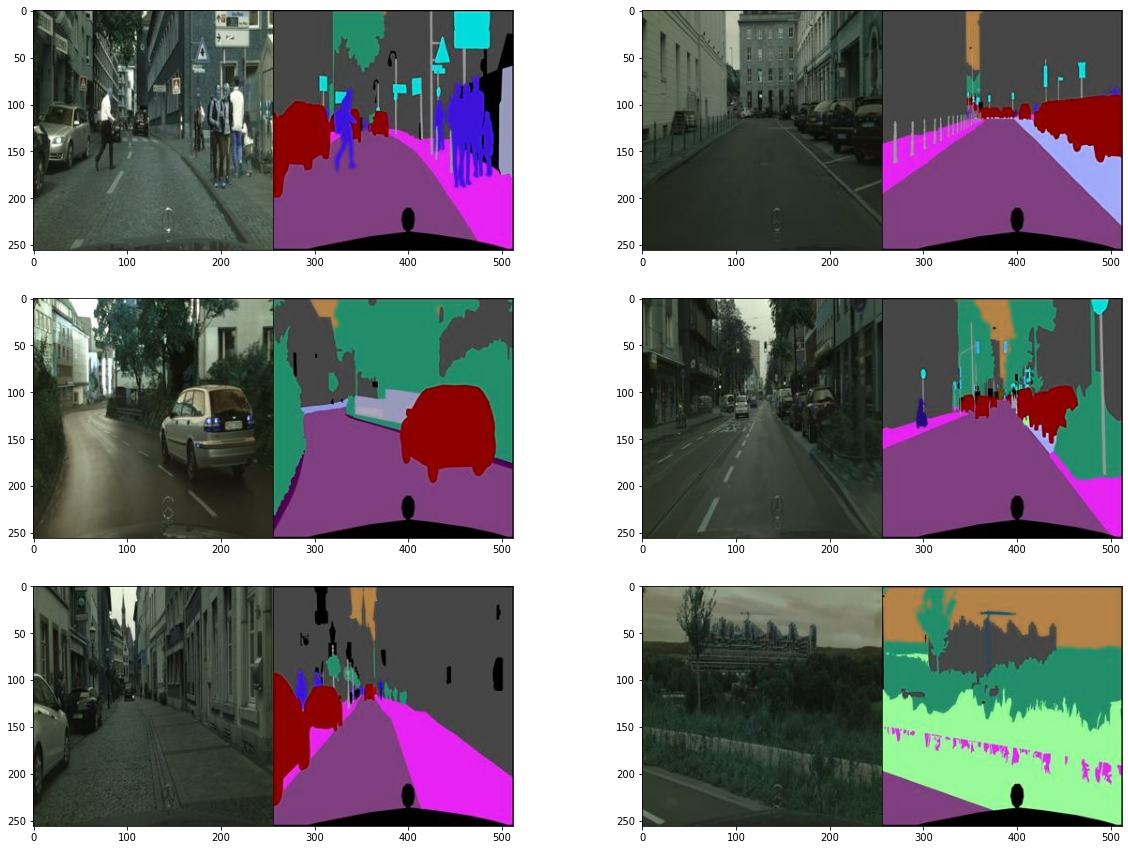

In [ ]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

### 이미지 크기 확인하기

In [ ]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


### 모델에 학습할 데이터 분할하기
- 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하기 위함

In [27]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    predicted = img[:, :w, :] 
    predicted = tf.cast(predicted, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(predicted)

Text(0.5, 1.0, 'Ground Truth')

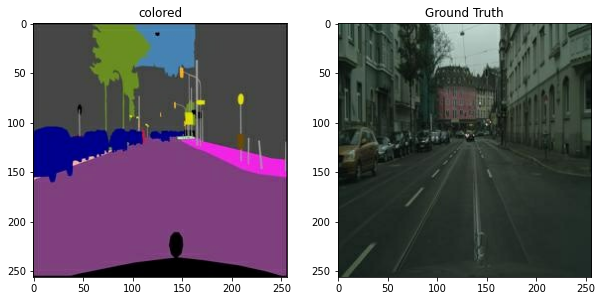

In [28]:
f = data_path + os.listdir(data_path)[1]
colored, predicted = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(colored)); plt.title('colored')
plt.subplot(1,2,2); plt.imshow(denormalize(predicted)); plt.title('Ground Truth')

## Augmentation 기법 적용하기
두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.

1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. `tf.pad`  
2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. `tf.image.random_crop`  
3.의 결과를 50% 확률로 가로로 뒤집습니다. `tf.image.random_flip_left_right`  
4.의 결과를 50% 확률로 세로로 뒤집습니다. `tf.image.random_flip_up_down`  
5.의 결과를 50% 확률로 회전시킵니다. `tf.image.rot90`  

In [ ]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

In [31]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_colored, augmented_predicted = apply_augmentation(colored, predicted)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_predicted)); plt.title(f"Image {img_n}")
    img_n += 1

InvalidArgumentError: ignored

<Figure size 1080x936 with 0 Axes>

## 최종 데이터 시각화하기

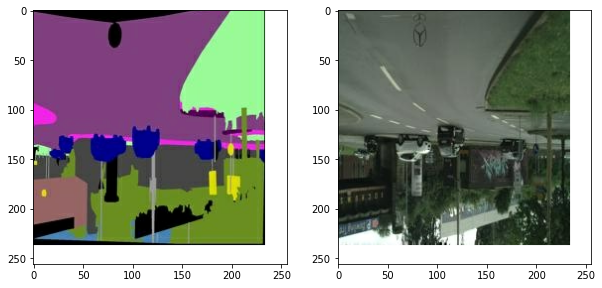

In [32]:
from tensorflow import data

def get_train(img_path):
    colored, predicted = load_img(img_path)
    colored, predicted = apply_augmentation(colored, predicted)
    return colored, predicted

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
colored, predicted = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(colored[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(predicted[0].astype(np.uint8))

# Generator
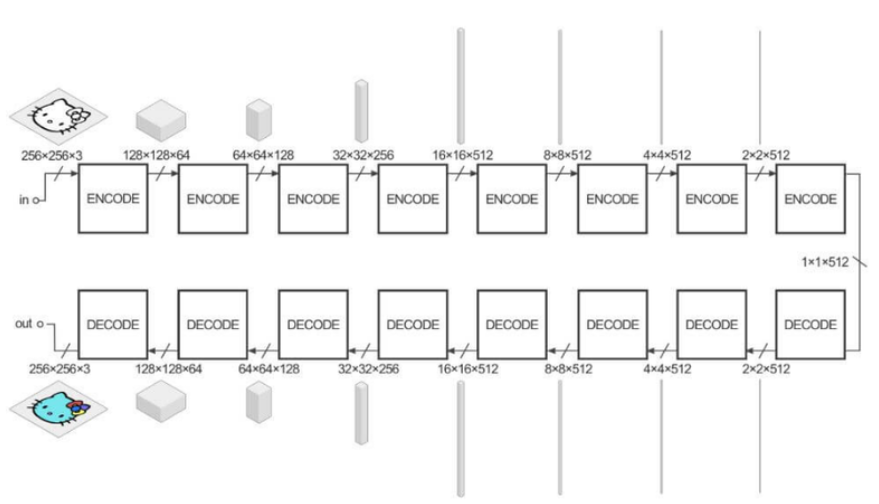
## Encode-Decoder Generator 구현하기

In [33]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

## U-Net Generator
- 아래 모델의 `__init__()` 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, `call()`에서 forward propagation 하도록 합니다. 이전 구현에는 없었던 skip connection이 `call()` 내부에서 구현합니다.
- 먼저, `__init__()` 에서 정의된 encode_blocks 및 decode_blocks가 `call()` 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다.
이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.  
이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.

In [34]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [35]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

# Discriminator
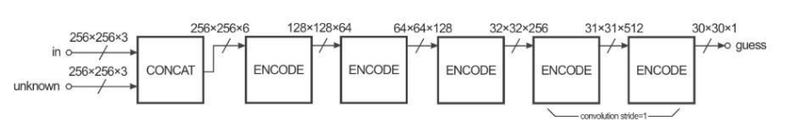
#### **Discriminator Block**
- `__init__()` 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다. 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능합니다.

In [36]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

### 각 출력의 크기 맞는지 확인하기

In [37]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_7 (ZeroPaddi  (None, 130, 130, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_55 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

#### **Discriminator Model**

In [38]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [39]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_87 (Concatenate)   (None, 256, 256, 6)  0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']          

### 크기가 (256, 256, 3)인 입력을 넣어 확인해보기 

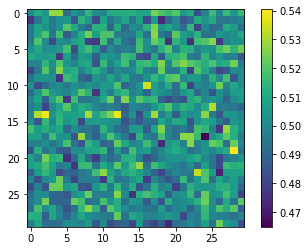

In [40]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 학습 및 테스트
## 손실함수 : L1 + cGAN

>**Generator의 손실 함수** (아래 코드의 `get_gene_loss`)는 총 3개의 입력이 있습니다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.

> **Discriminator의 손실 함수** (아래 코드의 `get_disc_loss`)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

In [41]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

## Optimizer

In [42]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

## 가중치 Update

In [43]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

## Train

In [44]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 250 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[250]                     
Generator_loss:1.8871                     
L1_loss:0.2093                     
Discriminator_loss:0.3568

EPOCH[2] - STEP[250]                     
Generator_loss:1.0183                     
L1_loss:0.2031                     
Discriminator_loss:0.7898

EPOCH[3] - STEP[250]                     
Generator_loss:2.7189                     
L1_loss:0.1756                     
Discriminator_loss:0.9288

EPOCH[4] - STEP[250]                     
Generator_loss:1.5471                     
L1_loss:0.1721                     
Discriminator_loss:1.4905

EPOCH[5] - STEP[250]                     
Generator_loss:1.1792                     
L1_loss:0.1994                     
Discriminator_loss:0.8502

EPOCH[6] - STEP[250]                     
Generator_loss:1.4693                     
L1_loss:0.1713                     
Discriminator_loss:1.1483

EPOCH[7] - STEP[250]                     
Generator_loss:1.5546                     
L1_loss:0.2042             

## Test

In [45]:
test_path = '/content/drive/MyDrive/Aiffel/Exploration17/cityscapes/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    colored, predicted = load_img(f)

    pred = generator(tf.expand_dims(colored, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored)); plt.title('colored')
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image')
    plt.subplot(1,3,3); plt.imshow(denormalize(predicted)); plt.title('Ground Truth')

Output hidden; open in https://colab.research.google.com to view.

# 🙌 회고 🙌



1.   epochs가 10으로 주어졌을 때 이미지가 제대로 생성되지 않아서, 100으로 해보았는데 꽤나 그럴싸한 이미지가 출력되었습니다. 그런데 여전히 흠이 있는건 데이터 수가 적기 때문일까요? 아니면 epoch가 더 커야하나요? 이 부분은 고민을 좀 더 해봐야 할 것 같습니다.  
2.   GAN 모델의 Encoder-Decoder 개념이 헷갈렸었는데 이번 노드에 설명이 너무 잘 나와있어서 이해하기 쉬웠습니다! 더 나아가 CGAN, patchGAN, U-Net 등 다양한 구조에 대해 배우며 얼마든지 또 새롭고 좋은 모델이 나올 수 있다는 가능성을 보게되어 좋았습니다. 
3. Data augmentation을 여러가지 방법으로 시행해볼 수 있어 좋았다. 사실 처음엔 이미지를 뒤집거나 돌리는게 얼마나 효과가 있을까 싶었는데 없을 때보다 나아진 듯 합니다. 이전에 데이터 증강 관련된 특강을 들었었는데, 혼자 논문 읽고 적용해볼 실력이 되면 다른 방법들도 사용해보면 좋을 것 같아요 🚀
4. 이로써 마지막 Exploration이 끝났네요. Going Deeper도 포기하지 않고 끝까지 완주하기를 ... ! 
